<a href="https://colab.research.google.com/github/rohanath123/Latent-Dirichlet-Allocation/blob/master/LDA_AUTOMOTIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd 
import re
from pprint import pprint 
import gensim 
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

In [2]:
import spacy
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_json('/content/drive/My Drive/Datasets/Automotive Review/Automotive_5.json', lines = True)

In [0]:
df = df.reviewText

In [0]:
data = df.values.tolist()

In [0]:
def sent_to_words(sentences):
  for sent in sentences:
    yield(gensim.utils.simple_preprocess(str(sent), deacc = True))

In [0]:
data_words = list(sent_to_words(data))
data_words[0]

In [0]:
stop_words = stopwords.words('english')

In [0]:
def remove_stopwords(texts):
  return([word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts)

In [0]:
data_words_nonstop = remove_stopwords(data_words) 

In [22]:
bigrams = gensim.models.Phrases(data_words, min_count = 5, threshold = 100)
trigrams = gensim.models.Phrases(bigrams[data_words], threshold = 100)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
bigram_mod = gensim.models.phrases.Phraser(bigrams)
trigram_mod = gensim.models.phrases.Phraser(trigrams)

In [0]:
def make_bigrams(texts):
  return([bigram_mod[doc] for doc in texts])
def make_trigrams(texts):
  return([trigram_mod[doc] for doc in texts])

In [0]:
def lemma(texts, allowed_postags = ['ADJ', 'ADV', 'VERB', 'NOUN']):
  texts_out = []
  for sent in texts:
    doc = nlp(" ".join(sent))
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return texts_out

In [0]:
data_words_bigrams = make_bigrams(data_words_nonstop)

In [0]:
nlp = spacy.load('en_core_web_sm', diable = ['parser', 'ner'])

In [0]:
data_lem = lemma(data_words_bigrams)

In [0]:
id2word = corpora.Dictionary(data_lem)

In [0]:
texts = data_lem

In [0]:
corpus = [id2word.doc2bow(text) for text in texts]

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = 15, passes = 10, id2word = id2word, alpha = 'auto', per_word_topics = True)

In [39]:
pprint(lda_model.print_topics())

[(0,
  '0.080*"oil" + 0.061*"filter" + 0.038*"change" + 0.018*"air" + 0.018*"use" + '
  '0.016*"pump" + 0.011*"engine" + 0.011*"drain" + 0.011*"mile" + '
  '0.009*"synthetic"'),
 (1,
  '0.083*"hose" + 0.031*"cap" + 0.029*"glove" + 0.022*"leak" + 0.020*"valve" + '
  '0.018*"sewer_hose" + 0.015*"cutting_board" + 0.015*"score" + '
  '0.012*"fitting" + 0.012*"grease"'),
 (2,
  '0.045*"car" + 0.023*"drive" + 0.016*"get" + 0.016*"day" + 0.013*"time" + '
  '0.012*"go" + 0.011*"start" + 0.010*"use" + 0.009*"see" + 0.008*"first"'),
 (3,
  '0.070*"battery" + 0.042*"power" + 0.041*"charge" + 0.026*"tire" + '
  '0.023*"use" + 0.021*"plug" + 0.020*"charger" + 0.018*"gauge" + 0.017*"unit" '
  '+ 0.013*"automatic"'),
 (4,
  '0.020*"cover" + 0.019*"tire" + 0.018*"wheel" + 0.016*"look" + 0.014*"door" '
  '+ 0.013*"tape" + 0.013*"area" + 0.012*"plastic" + 0.012*"surface" + '
  '0.012*"brush"'),
 (5,
  '0.153*"blade" + 0.132*"water" + 0.025*"nozzle" + 0.024*"usb" + '
  '0.021*"bucket" + 0.016*"hose" + 0.

In [40]:
from gensim.models import CoherenceModel
coh = CoherenceModel(lda_model, texts = data_lem, dictionary = id2word)
coh.get_coherence()

0.47516938070058473

In [0]:
model_scores = []
def test_models():
  #every 3 topics starting from 5 to 30 or something
  for i in range(10):
    print("Iteration = ", i+1)
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = (5+i*3), id2word=id2word, passes = 10, alpha = 'auto', per_word_topics= True)
    coh = CoherenceModel(lda_model, texts = data_lem, dictionary = id2word)
    model_scores.append(coh.get_coherence())

In [48]:
test_models()

Iteration =  1
Iteration =  2
Iteration =  3
Iteration =  4
Iteration =  5
Iteration =  6
Iteration =  7
Iteration =  8
Iteration =  9
Iteration =  10


In [49]:
model_scores

[0.3939541255477976,
 0.45126841284528707,
 0.4446873667599302,
 0.46650689204498275,
 0.4808595330299227,
 0.45977962422897745,
 0.4593485697295227,
 0.45133919174282217,
 0.44632157764635305,
 0.43499669335772595,
 0.42303399031400934,
 0.4283859631754213,
 0.4857005219566968,
 0.45109762330022196,
 0.45992834863198534,
 0.5066315728363933,
 0.42963410345542846,
 0.4614439367653832,
 0.46175538909155356,
 0.45087448468325]

In [0]:
x = [5+i*3 for i in range(10)]

In [55]:
len(model_scores)

20

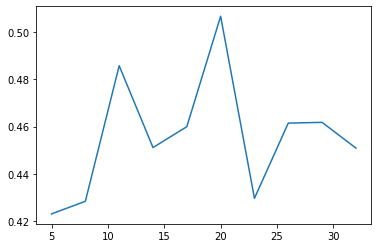

In [56]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(x, model_scores[10:20])
plt.show()

In [57]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = 20, id2word=id2word, passes = 10, alpha = 'auto', per_word_topics= True)
coh = CoherenceModel(lda_model, texts = data_lem, dictionary = id2word)
print(coh.get_coherence())

0.44819370367983036


In [58]:
lda_model.print_topics()

[(0,
  '0.034*"use" + 0.032*"car" + 0.026*"clean" + 0.025*"towel" + 0.022*"dry" + 0.018*"product" + 0.018*"wash" + 0.015*"wax" + 0.014*"leather" + 0.013*"water"'),
 (1,
  '0.095*"battery" + 0.056*"charge" + 0.053*"power" + 0.027*"charger" + 0.024*"mat" + 0.022*"use" + 0.021*"unit" + 0.021*"car" + 0.015*"plug" + 0.014*"cable"'),
 (2,
  '0.018*"handle" + 0.016*"small" + 0.015*"plastic" + 0.015*"hold" + 0.014*"side" + 0.013*"place" + 0.012*"large" + 0.011*"lock" + 0.010*"make" + 0.010*"easy"'),
 (3,
  '0.032*"adapter" + 0.025*"connect" + 0.024*"port" + 0.021*"include" + 0.020*"information" + 0.020*"connector" + 0.019*"laptop" + 0.015*"output" + 0.015*"location" + 0.013*"vehicle"'),
 (4,
  '0.028*"use" + 0.026*"work" + 0.023*"get" + 0.022*"well" + 0.019*"good" + 0.015*"car" + 0.015*"make" + 0.015*"great" + 0.014*"would" + 0.014*"product"'),
 (5,
  '0.148*"oil" + 0.114*"filter" + 0.066*"change" + 0.022*"score" + 0.018*"air" + 0.018*"synthetic" + 0.014*"mile" + 0.013*"tablet" + 0.013*"oem" +